# ADS 505 Final Project

Team Members:

Dallin Munger
Aubrey Barrett
Omar Elfeky

Github Link: https://github.com/dmunger27/elderfraud-detection

**Problem Statement**

With the rise in digital banking, new problems are being faced by the banking industry. One of these issues is how to protect customers from fraudulent activity in digital payments, especially elderly and dependent adults. These individuals are most susceptible to fraud and often will not report fraud when it occurs.

**Proposed Solution**

To solve this growing problem, we developed a machine learning model to predict and identify these potentially fraudulent transactions. This will help banks be more prepared for the continued growth in digital transactions, and it will aid them in protecting their most vulnerable customers.

### Table of Contents

* [Exploratory Data Analysis](#eda)
* [Data Wrangling and Pre-Processing](#preprocess)
* [Modeling Strategies, Validation, and Testing](#model)
* [Results and Conclusions](#results)

In [52]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from scipy import stats
import statistics

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import time
# Import the scikitplot module
import scikitplot as skplt

#Book Libraries
from dmba import liftChart, gainsChart,regressionSummary, classificationSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection, adjusted_r2_score, AIC_score, BIC_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score, roc_curve, auc,roc_auc_score,plot_confusion_matrix,confusion_matrix,r2_score

#Classification 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression,  LinearRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


In [58]:
#Note 1: In the train dataset there is no 'dataset_id' column. We will need to drop it from the test DF.
df_train = pd.read_excel('b765dc3d8076-trainset+(1).xlsx')

#Note 1: In the test dataset there is no 'FRAUD_NONFRAUD' column but there is 'dataset_id' column.
df_test = pd.read_excel('b765dc3d8076-testset_for_participants.xlsx').drop(columns = ['dataset_id'])

print("The shape of the training data is: ", df_train.shape)
print("The missing values are:")
#Uncomment the line below to see the train missing values.
#print(df_train.isnull().sum(),'\n')

print("The shape of the test data is: ", df_test.shape)
print("The missing values are:")
#Uncomment the line below to see the test NaN values.
df_test.isnull().sum()

The shape of the training data is:  (14000, 24)
The missing values are:
The shape of the test data is:  (6000, 23)
The missing values are:


TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
PWD_UPDT_TS                1318
CARR_NAME                  1175
RGN_NAME                   1175
STATE_PRVNC_TXT            1175
ALERT_TRGR_CD                 0
DVC_TYPE_TXT                803
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT        26
CUST_ZIP                      0
CUST_STATE                   22
PH_NUM_UPDT_TS             3036
CUST_SINCE_DT                 0
TRAN_TS                       0
TRAN_DT                       0
ACTN_CD                       0
ACTN_INTNL_TXT                0
TRAN_TYPE_CD                  0
ACTVY_DT                      0
dtype: int64

## Data Wrangling and Pre-Processing<a class="anchor" id="preprocess"></a>

To prepare the data for modeling, a number of preprocessing steps were taken. First, the length of time an individual has been a customer was subtracted from their age. This was then added as a new variable to both the test and training datasets.

Redundant variables were then removed from the datasets.

In [59]:
#Number of years from customer since date to activity date, then compare that to the customer age - if the difference is low, fraudulent activity may be likely
df_train['AGE_CUST_LENGTH_DIFF'] = (df_train['CUST_AGE'] - (df_train['ACTVY_DT'].astype('datetime64') - df_train['CUST_SINCE_DT']).dt.days/365).round().astype(int)
df_test['AGE_CUST_LENGTH_DIFF'] = (df_test['CUST_AGE'] - (df_test['ACTVY_DT'].astype('datetime64') - df_test['CUST_SINCE_DT']).dt.days/365).round().astype(int)

In [60]:
#Droppimg ACTVY_DT and TRAN_DT since they are redundant to TRAN_TS.
df_train = df_train.drop(columns = ['ACTVY_DT', 'TRAN_DT','TRAN_TS'])
df_test = df_test.drop(columns = ['ACTVY_DT', 'TRAN_DT','TRAN_TS'])

#Dropping RGN_NAME since it is redundant to STATE_PRVNC_TXT.
df_train = df_train.drop(columns = ['RGN_NAME'])
df_test = df_test.drop(columns = ['RGN_NAME'])

#The columns below were checked and have no variation.
column_values = df_train[['ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTN_CD']].values.ravel()
unique_values = pd.unique(column_values)
print(unique_values)
df_train = df_train.drop(columns = ['ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTN_CD'])
df_test = df_test.drop(columns = ['ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTN_CD'])

['P2P_COMMIT' 'P2P' 'SCHPMT']


A label encoder was then used on categorical variables to use numbers to represent categories instead of strings. Timestamps were then updated and the missing values for when the password was last updated were changed to the date the account was created.

Timestamps were then adjusted and standardized.

In [35]:
label_encoder = preprocessing.LabelEncoder()
# Encode labels
df_train['ALERT_TRGR_CD']= label_encoder.fit_transform(df_train['ALERT_TRGR_CD'])
#NaN's in STATE_PRVNC_TXT left on purpose because overseas access would not be a state. Note has 128 unique values.
df_train['STATE_PRVNC_TXT']= label_encoder.fit_transform(df_train['STATE_PRVNC_TXT']) 
#DVC_TYPE_TXT and AUTHC_SCNDRY_STAT_TXT have NaN values less than 30%
df_train['AUTHC_SCNDRY_STAT_TXT']= label_encoder.fit_transform(df_train['AUTHC_SCNDRY_STAT_TXT']) 
df_train['DVC_TYPE_TXT']= label_encoder.fit_transform(df_train['DVC_TYPE_TXT'])
           
df_train['FRAUD_NONFRAUD']= label_encoder.fit_transform(df_train['FRAUD_NONFRAUD'])
df_train['AUTHC_PRIM_TYPE_CD']= label_encoder.fit_transform(df_train['AUTHC_PRIM_TYPE_CD'])
    
#typo for google llc corrected.
df_train['CARR_NAME'] = df_train['CARR_NAME'].replace('google  llc', 'google llc')
#NaN's in CARR_NAME left on purpose to have own label because ISP could be hidden. Some are overseas ISPs.
df_train['CARR_NAME']= label_encoder.fit_transform(df_train['CARR_NAME']) 
df_train['CUST_STATE']= label_encoder.fit_transform(df_train['CUST_STATE']) 

In [36]:
#There is no 6/31/ date, change to 7/1/ (element 1322)
df_train['PWD_UPDT_TS']=df_train['PWD_UPDT_TS'].replace(to_replace ="6/31/", value ="7/01/", regex = True)

#Change the password change timestamp (PWD_UPDT_TS) to months since changed.
df_train['PWD_UPDT_TS'] = df_train['PWD_UPDT_TS'].fillna('01/01/1970 0:0:0')

passwordupdated_timestamp = []
for element in df_train.PWD_UPDT_TS:
#    print(element)
    passwordupdated_timestamp.append(pd.to_datetime(element, format='%m/%d/%Y %H:%M:%S').timestamp())
df_train['PWD_UPDT_TS'] = passwordupdated_timestamp 

#Scale the password change timestamp (PWD_UPDT_TS)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train['PWD_UPDT_TS'] = scaler.fit_transform(df_train['PWD_UPDT_TS'].values.reshape(-1,1))

In [37]:
#Change last password change to date customer made account
customersince_timestamp = []
today = pd.Timestamp('now')
for element in df_train.CUST_SINCE_DT: 
    difference = today.year - element.year - ((today.month, today.day) < (element.month, element.day))
    customersince_timestamp.append(difference)
df_train['CUST_SINCE_DT'] = customersince_timestamp 

In [38]:
df_train['PH_NUM_UPDT_TS']=df_train['PH_NUM_UPDT_TS'].replace(to_replace ="/0/", value ="/12/",regex= True)
#Change last phone number change to date customer made account
phonenumn_timestamp = []
for index, row in df_train.iterrows():
    #rint(df_train)string != string
    if(row.PH_NUM_UPDT_TS !=row.PH_NUM_UPDT_TS):
        phonenumn_timestamp.append(row.CUST_SINCE_DT)
        #element.PH_NUM_UPDT_TS = element.CUST_SINCE_DT 
    else:
        time = pd.to_datetime(row.PH_NUM_UPDT_TS, format='%m/%d/%Y %H:%M:%S')#timestamp()
        print(time)
        difference = today.year - time.year - ((today.month, today.day) < (time.month, time.day))
        phonenumn_timestamp.append(difference)
df_train['PH_NUM_UPDT_TS'] = phonenumn_timestamp 

2021-02-24 15:55:10
2019-05-05 01:08:39
2019-02-16 06:45:37
2020-05-08 10:27:06
2021-05-18 09:50:05
2018-03-16 16:50:05
2019-07-28 12:04:47
2019-12-06 06:04:06
2017-05-12 10:54:10
2020-07-15 06:50:42
2018-05-01 14:50:05
2019-05-06 06:27:47
2020-06-08 19:45:37
2018-07-20 11:22:46
2020-05-16 19:50:05
2020-02-19 10:02:48
2017-07-11 06:31:17
2020-05-18 12:50:05
2019-04-16 06:45:37
2019-10-10 09:23:20
2019-03-12 13:50:05
2019-07-28 06:45:37
2020-02-13 10:08:17
2018-07-01 18:45:37
2018-09-26 06:21:29
2017-12-05 08:25:31
2019-05-05 14:58:44
2020-01-08 06:45:37
2020-01-08 11:45:37
2020-07-08 14:45:37
2020-07-08 08:45:37
2018-04-23 09:45:37
2017-05-09 14:50:05
2019-07-07 06:05:44
2018-01-21 16:51:01
2020-05-21 23:06:57
2017-05-17 13:57:24
2019-05-01 10:30:02
2020-05-12 06:21:16
2020-07-08 06:45:37
2017-05-08 06:10:51
2021-05-24 16:09:26
2017-05-28 11:50:05
2020-05-07 23:34:43
2020-07-21 06:45:37
2017-05-14 10:14:15
2020-05-22 23:03:13
2020-11-10 11:48:25
2019-05-21 11:13:23
2019-12-02 14:14:59


2019-12-03 01:39:55
2020-04-12 11:50:05
2020-05-12 10:12:31
2018-10-25 06:30:32
2018-12-03 06:45:37
2017-06-08 06:45:37
2020-11-22 10:41:02
2017-07-27 06:39:40
2019-04-08 06:23:32
2018-07-28 06:45:37
2019-07-08 17:19:34
2019-01-24 15:04:17
2020-05-05 09:08:00
2020-05-25 23:25:48
2020-08-29 13:50:13
2020-01-18 06:45:37
2020-07-12 06:45:37
2020-05-07 13:59:07
2019-06-18 14:51:03
2020-05-12 19:34:10
2019-10-04 02:50:45
2019-07-04 17:45:37
2017-07-20 07:45:37
2020-07-21 07:23:56
2018-05-05 20:50:05
2018-06-11 06:41:31
2021-05-04 23:50:05
2019-04-26 06:07:36
2018-07-31 14:45:37
2017-03-08 18:45:37
2019-02-22 06:56:11
2020-12-08 14:56:57
2021-05-30 22:11:37
2019-02-16 08:50:05
2017-04-17 05:45:37
2020-10-12 14:00:14
2019-07-15 06:17:10
2019-09-18 14:45:37
2020-01-17 13:50:05
2017-07-13 06:07:50
2020-05-12 13:36:22
2018-05-14 05:21:00
2019-05-21 23:28:54
2017-07-25 06:21:00
2020-05-13 11:47:18
2017-08-02 18:39:00
2019-03-12 06:22:02
2018-07-25 12:45:37
2021-05-07 13:50:05
2020-11-09 15:06:47


2019-03-08 16:45:37
2018-02-08 13:45:37
2021-05-12 23:40:23
2019-11-18 02:28:57
2019-12-28 21:12:48
2021-10-24 20:53:17
2021-09-22 10:10:33
2020-05-03 15:20:54
2020-05-18 00:16:12
2018-05-12 13:24:03
2017-03-28 15:54:14
2019-12-19 05:52:38
2020-12-08 06:02:42
2020-05-25 07:14:18
2020-11-25 06:47:51
2018-09-25 22:25:56
2020-02-18 07:45:37
2020-05-12 23:54:28
2017-07-23 06:29:52
2019-09-30 18:17:04
2020-05-08 01:45:37
2020-12-06 09:50:05
2020-05-03 07:33:17
2018-12-03 09:50:05
2019-03-13 06:45:37
2020-08-12 13:59:39
2019-01-26 06:04:34
2018-09-11 13:36:39
2019-07-08 17:20:20
2019-09-08 10:45:37
2020-08-14 10:30:40
2021-01-20 18:58:21
2017-05-17 19:23:46
2018-03-05 07:20:00
2018-03-27 06:24:41
2020-07-11 14:49:28
2018-07-05 16:37:16
2020-12-08 14:45:37
2017-07-08 09:10:34
2019-01-18 06:45:37
2017-03-18 11:53:45
2020-01-07 07:37:34
2019-11-01 13:45:37
2020-09-24 22:47:48
2017-04-08 09:45:37
2019-08-16 12:42:04
2017-09-17 06:45:37
2017-05-16 21:50:00
2020-08-08 06:45:37
2019-06-07 12:10:40


2017-07-08 09:06:11
2018-07-11 06:46:17
2020-01-15 09:50:05
2018-07-11 00:51:58
2020-09-25 09:45:37
2019-02-08 20:45:37
2018-07-23 06:35:14
2019-10-12 15:23:56
2019-03-08 07:45:37
2019-02-28 14:22:58
2019-07-31 07:45:37
2021-07-26 20:52:19
2020-03-21 09:01:36
2019-07-05 06:45:37
2020-07-08 06:35:02
2019-07-09 21:25:16
2019-07-13 06:44:17
2019-09-29 07:43:16
2020-05-12 15:50:05
2019-07-19 10:00:18
2017-09-12 17:25:55
2018-01-05 18:59:46
2017-01-13 06:52:33
2020-11-03 23:05:05
2019-01-15 16:45:37
2019-12-20 18:28:45
2019-07-25 06:45:37
2017-02-16 06:45:37
2020-07-25 08:45:37
2020-03-11 06:45:37
2018-06-06 10:38:18
2020-12-30 05:45:37
2018-09-14 10:45:37
2019-05-29 14:29:51
2017-02-07 06:17:12
2020-05-22 09:40:02
2020-05-28 08:04:56
2017-05-11 16:28:33
2019-01-05 12:45:37
2019-06-29 06:45:37
2017-12-28 01:45:37
2020-02-09 03:50:05
2018-08-13 12:48:50
2018-09-08 06:04:39
2021-10-16 10:32:17
2019-07-07 16:37:22
2020-05-25 15:50:05
2019-07-01 08:07:31
2021-05-12 01:29:59
2021-01-17 06:20:17


2020-07-23 06:47:46
2017-07-25 06:08:32
2019-10-06 10:45:09
2020-03-24 13:46:52
2018-01-06 09:23:07
2021-05-15 13:02:11
2020-05-17 08:13:25
2020-10-27 12:33:33
2019-07-02 20:45:37
2017-06-02 14:45:37
2021-01-08 23:05:33
2020-09-22 11:45:02
2018-08-23 23:19:24
2019-07-02 13:09:20
2020-11-08 11:45:37
2020-05-14 11:01:03
2018-03-08 16:45:37
2017-10-12 11:32:33
2019-07-08 06:12:04
2020-05-24 23:10:02
2018-01-09 06:48:51
2020-04-08 06:45:37
2019-06-23 07:45:37
2020-07-31 08:25:31
2018-07-16 15:13:53
2019-06-13 06:19:25
2019-07-29 06:49:12
2017-03-08 07:45:37
2019-02-11 06:22:48
2019-06-08 11:49:15
2020-05-04 10:37:31
2020-05-08 07:47:48
2020-05-03 13:36:42
2019-07-12 17:58:22
2021-07-09 13:45:37
2019-07-01 10:09:26
2019-08-23 06:45:37
2020-08-02 14:58:06
2019-07-03 06:45:37
2017-07-26 06:45:37
2018-07-26 06:45:37
2020-05-06 14:56:27
2020-05-08 10:45:37
2019-08-26 06:18:03
2018-12-11 08:16:39
2021-01-19 12:10:26
2019-07-14 06:45:37
2017-06-26 17:56:44
2020-08-07 06:58:44
2020-03-14 11:47:33


2017-11-29 12:39:49
2017-04-08 09:56:39
2019-05-22 07:50:05
2019-04-28 06:03:41
2020-05-12 10:13:04
2020-05-08 06:45:37
2020-06-15 06:08:27
2019-07-09 12:44:20
2020-12-13 19:45:37
2020-05-12 02:50:05
2019-07-08 08:07:08
2020-05-27 14:59:56
2020-06-12 11:14:59
2018-07-08 21:45:37
2021-04-22 06:01:04
2020-05-17 23:45:56
2020-07-12 07:50:05
2019-12-08 10:01:53
2021-08-28 10:50:05
2020-05-22 23:06:01
2017-10-24 06:10:00
2021-05-12 14:50:05
2021-01-25 02:00:41
2020-01-15 11:00:36
2017-09-08 11:02:34
2017-05-12 15:03:26
2019-02-08 18:38:09
2020-05-25 11:44:38
2020-12-09 13:02:08
2021-12-08 17:31:18
2021-05-28 23:29:45
2021-12-23 08:15:32
2017-12-15 01:36:34
2020-07-23 22:42:28
2018-12-08 10:45:37
2019-05-03 10:41:35
2017-10-05 17:23:37
2020-11-05 23:08:20
2019-07-25 06:24:23
2021-07-03 12:38:55
2021-05-07 18:49:52
2020-05-13 12:50:05
2019-05-16 23:59:05
2017-03-26 14:50:05
2021-07-25 08:02:21
2019-07-08 06:45:37
2019-05-23 16:54:27
2020-05-21 07:55:10
2021-02-21 09:58:50
2021-01-26 23:41:03


2020-07-08 06:18:56
2020-11-28 12:50:05
2021-05-05 17:22:55
2021-10-13 11:21:50
2021-07-15 06:45:37
2021-03-12 20:39:04
2020-05-08 21:33:05
2019-11-12 13:20:13
2019-07-17 13:45:37
2019-04-24 15:08:08
2020-04-01 05:57:20
2020-07-24 06:03:15
2018-07-24 06:00:14
2019-05-21 13:50:05
2019-08-29 07:20:26
2018-02-12 23:39:09
2018-07-20 11:14:29
2020-04-02 13:00:17
2018-01-04 23:50:04
2019-07-29 06:45:37
2020-05-26 09:40:30
2018-07-08 09:58:35
2017-07-08 13:45:37
2018-07-28 06:02:40
2020-12-01 14:54:05
2018-03-16 19:59:23
2019-07-15 12:53:02
2017-07-12 19:22:32
2021-08-08 11:45:37
2021-02-08 14:16:13
2019-08-21 06:45:37
2020-05-28 09:45:12
2017-05-29 10:27:45
2019-05-27 10:41:54
2020-03-08 06:55:25
2019-12-11 06:33:26
2020-01-12 22:50:05
2021-12-02 07:50:05
2020-03-11 15:32:37
2018-05-25 10:20:00
2018-04-16 19:51:50
2018-05-01 02:50:05
2021-08-13 23:23:19
2019-07-29 14:45:37
2019-05-17 15:50:05
2020-07-29 06:45:37
2020-08-10 09:37:18
2019-10-28 06:45:37
2019-08-03 06:07:24
2019-05-18 23:06:40


2018-07-24 06:19:14
2020-05-21 13:06:26
2018-01-28 10:50:50
2020-02-01 11:21:11
2020-05-02 23:50:05
2021-05-09 19:50:05
2017-05-25 16:49:40
2020-07-13 10:45:37
2020-08-28 10:45:37
2017-10-09 06:45:37
2021-10-17 23:13:18
2021-07-20 14:31:13
2020-10-14 17:13:59
2020-07-31 02:45:37
2019-08-05 06:45:37
2018-03-08 06:57:34
2020-07-27 12:50:05
2020-05-01 16:50:05
2021-05-12 19:17:16
2020-02-17 08:34:03
2020-05-08 11:50:05
2020-05-16 07:23:50
2019-08-08 08:59:34
2017-06-15 23:09:33
2019-07-16 06:29:44
2020-01-05 14:45:37
2021-06-08 06:12:43
2018-06-29 06:45:37
2020-01-08 12:43:36
2020-09-05 07:38:43
2020-06-29 06:18:03
2018-11-06 08:43:21
2020-10-04 23:57:52
2021-10-02 16:45:37
2018-08-19 21:14:22
2019-06-17 12:45:37
2017-06-08 11:30:01
2019-03-08 18:07:23
2020-03-12 23:04:27
2017-07-21 14:15:03
2017-12-28 12:45:37
2019-11-29 15:16:32
2018-02-28 09:05:27
2019-05-10 05:50:05
2018-09-18 17:29:06
2017-10-20 14:45:37
2020-07-27 12:45:37
2020-05-23 13:50:05
2020-07-08 23:56:28
2017-07-08 06:55:29


2020-07-12 17:23:23
2019-07-08 06:45:37
2020-07-03 09:45:37
2019-09-08 06:11:55
2021-10-27 04:45:37
2018-07-08 12:55:27
2020-02-26 15:45:37
2020-10-06 13:24:28
2019-11-08 06:42:41
2019-04-08 06:38:10
2017-06-08 23:50:05
2020-05-23 14:06:02
2021-05-25 13:47:34
2020-08-21 12:06:01
2020-01-08 14:42:22
2019-08-08 17:40:00
2020-05-10 11:18:42
2019-10-04 17:06:59
2020-09-27 21:19:51
2020-08-07 12:45:37
2020-05-15 14:50:05
2020-05-13 22:50:05
2020-05-14 15:12:09
2019-02-11 00:46:34
2021-07-08 06:33:45
2021-11-08 12:42:33
2018-10-05 09:52:15
2020-05-26 15:07:56
2017-05-08 23:50:05
2017-05-30 12:44:21
2018-04-10 09:31:26
2020-07-08 08:13:49
2020-01-08 06:45:37
2017-11-21 09:45:37
2018-02-28 08:22:43
2019-01-13 06:35:08
2020-03-05 06:14:52
2020-07-08 06:09:20
2021-04-27 18:17:20
2018-07-08 20:45:37
2019-06-16 06:45:37
2019-07-08 12:45:37
2017-07-16 23:00:39
2021-05-30 08:08:55
2020-05-02 16:56:22
2019-05-05 23:29:20
2018-09-26 23:45:24
2020-05-08 09:50:05
2021-05-26 16:30:59
2017-10-18 13:15:25


2017-01-04 06:29:38
2020-05-07 14:47:48
2020-05-12 18:17:43
2021-02-18 12:45:37
2020-05-15 15:53:15
2018-01-02 09:01:50
2019-05-19 02:53:14
2020-12-08 06:49:26
2020-01-24 18:41:04
2018-09-02 10:50:05
2018-12-30 16:45:37
2020-11-17 23:50:05
2020-05-22 11:15:36
2020-01-04 12:54:09
2017-07-04 12:23:41
2020-09-08 06:19:59
2020-05-08 06:38:10
2020-05-12 14:10:23
2020-07-16 15:05:29
2021-06-11 20:50:05
2017-07-08 18:40:59
2017-12-18 15:40:35
2020-01-05 13:31:51
2017-11-05 11:15:51
2020-12-08 06:45:37
2020-03-18 15:08:41
2018-08-05 04:45:37
2020-10-08 00:46:31
2020-06-02 15:42:48
2021-03-01 15:45:37
2020-05-26 01:42:17
2019-05-12 13:50:05
2021-09-11 06:31:34
2019-02-05 10:07:40
2020-02-04 11:05:59
2021-09-25 11:40:23
2021-10-19 23:26:04
2018-03-26 10:11:06
2020-05-14 23:35:57
2018-07-11 19:45:37
2019-02-09 06:45:37
2020-05-18 16:50:05
2020-05-04 20:50:01
2020-05-12 14:50:05
2018-07-15 12:54:58
2019-07-11 17:57:28
2020-05-13 08:11:35
2017-02-27 11:58:49
2020-03-19 01:40:00
2020-01-04 06:36:22


2020-03-17 21:05:17
2021-02-12 12:04:30
2020-06-21 13:50:05
2019-03-23 07:01:31
2018-07-01 06:25:52
2018-04-29 14:50:05
2017-05-12 17:50:05
2020-05-06 12:31:25
2020-09-08 07:30:42
2018-07-12 13:48:16
2020-01-15 14:39:49
2019-07-08 06:01:17
2020-11-12 23:12:31
2020-05-08 18:45:12
2017-01-23 06:34:15
2020-05-17 23:08:04
2017-06-06 09:45:19
2021-04-05 12:50:05
2020-06-12 23:39:20
2020-10-25 10:50:05
2017-09-08 11:45:37
2020-05-12 15:44:36
2020-07-10 06:22:54
2019-07-10 14:52:16
2021-07-05 17:45:37
2020-11-17 10:57:04
2017-12-07 06:45:37
2019-11-13 03:05:42
2017-06-08 06:45:37
2018-01-08 11:45:37
2019-07-11 16:45:37
2020-05-02 11:50:05
2020-03-22 06:57:23
2017-07-26 09:08:23
2019-05-22 12:56:20
2018-01-28 23:50:05
2020-09-12 09:34:27
2017-11-29 17:45:37
2019-10-21 17:45:37
2020-05-12 01:50:05
2021-06-08 15:50:17
2020-08-27 19:45:37
2020-08-03 12:41:13
2020-07-07 14:36:42
2018-05-27 23:32:26
2020-05-02 00:35:24
2020-02-08 10:07:46
2018-07-22 06:45:37
2020-11-19 07:22:33
2017-07-08 06:43:38


2020-05-12 10:03:02
2019-07-08 06:06:02
2021-07-08 15:06:55
2019-03-08 12:56:53
2019-07-08 11:45:37
2020-02-26 17:45:37
2017-05-12 20:26:02
2020-07-25 12:49:55
2020-07-28 21:13:55
2020-07-29 20:08:25
2020-11-05 13:50:05
2020-05-24 10:07:24
2018-07-12 23:54:47
2019-08-29 03:35:46
2020-09-13 13:50:05
2017-05-17 08:29:39
2019-04-23 12:34:48
2020-06-08 13:50:42
2020-07-15 20:51:03
2019-12-19 03:45:37
2019-06-27 02:18:59
2020-07-12 09:02:59
2018-02-02 08:50:05
2019-08-12 15:53:52
2018-07-08 11:07:31
2020-08-21 12:27:30
2019-05-07 19:45:37
2020-01-03 01:04:57
2019-09-28 06:23:52
2019-05-24 09:43:05
2020-05-09 23:52:54
2019-07-18 06:45:37
2021-08-02 13:50:05
2021-06-30 06:45:37
2019-09-24 07:45:37
2019-08-29 17:10:39
2020-10-13 01:03:05
2018-07-27 18:52:49
2020-09-13 08:50:05
2020-02-08 06:45:37
2019-02-08 14:24:43
2018-05-17 12:11:28
2020-01-31 13:46:48
2020-08-04 15:34:59
2019-05-08 19:45:37
2021-04-12 19:11:36
2017-04-08 06:57:07
2020-07-07 06:42:05
2017-10-08 06:53:40
2020-05-03 16:50:05


## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In order to better understand the variables, both numeric and categorical, the plots below were produced. Bars for the frequency of a category or numeric range are shown, along with a density curve. An interesting note is the bimodality of the transaction amount variable. The account pre-transaction available balance also demonstrates a right-skewed distribution.

A correlation heatmap of the numeric variables is also visualized. None of these variables have a strong relationship besides age and the difference between age and the number of years someone has been a customer. The correlation between all variables was then calculated along with the variance of each variable.

In [ ]:
# create distplots
for column in df_train.columns:
    plt.figure()            
    sns.distplot(df_train[column])
    plt.figure()

In [40]:
print(df_train.info())

#Uncomment below for more df_test specific info.
#df_test, df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TRAN_AMT                 14000 non-null  float64
 1   ACCT_PRE_TRAN_AVAIL_BAL  14000 non-null  float64
 2   CUST_AGE                 14000 non-null  int64  
 3   OPEN_ACCT_CT             14000 non-null  int64  
 4   WF_dvc_age               14000 non-null  int64  
 5   PWD_UPDT_TS              14000 non-null  float64
 6   CARR_NAME                14000 non-null  int64  
 7   STATE_PRVNC_TXT          14000 non-null  int64  
 8   ALERT_TRGR_CD            14000 non-null  int64  
 9   DVC_TYPE_TXT             14000 non-null  int64  
 10  AUTHC_PRIM_TYPE_CD       14000 non-null  int64  
 11  AUTHC_SCNDRY_STAT_TXT    14000 non-null  int64  
 12  CUST_ZIP                 14000 non-null  int64  
 13  CUST_STATE               14000 non-null  int64  
 14  PH_NUM_UPDT_TS        

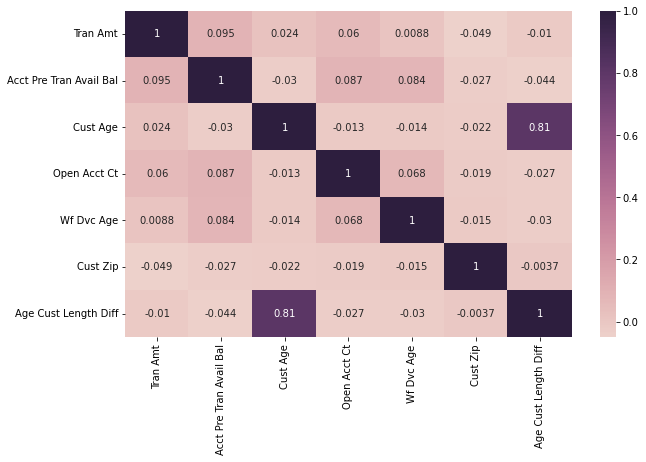

In [61]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(df_train.select_dtypes(include=['number', 'bool']).columns.values)]
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df_train.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [42]:
df_train.corr()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,FRAUD_NONFRAUD
TRAN_AMT,1.000000,0.095355,0.023688,0.059517,0.008768,0.024224,0.160326,0.183059,0.066776,0.067023,-0.027560,0.102517,-0.048676,0.033170,-0.060078,0.049178,-0.336169
ACCT_PRE_TRAN_AVAIL_BAL,0.095355,1.000000,-0.030382,0.087180,0.083629,-0.045865,-0.009522,0.000517,0.000482,0.041920,-0.089232,0.101859,-0.027318,0.013088,0.001469,0.032254,0.011808
CUST_AGE,0.023688,-0.030382,1.000000,-0.013212,-0.013567,0.023067,0.015183,0.015383,0.006454,0.008598,0.020462,0.008780,-0.022149,0.009614,-0.004462,-0.008191,-0.044426
OPEN_ACCT_CT,0.059517,0.087180,-0.013212,1.000000,0.068204,-0.054267,-0.024850,-0.007871,-0.000547,0.021521,-0.097997,0.111577,-0.018918,0.017719,0.010689,0.028008,0.051024
WF_dvc_age,0.008768,0.083629,-0.013567,0.068204,1.000000,-0.065153,-0.094691,-0.080916,-0.011612,0.028062,-0.080541,0.072239,-0.014835,0.023803,0.036605,0.031449,0.116179
PWD_UPDT_TS,0.024224,-0.045865,0.023067,-0.054267,-0.065153,1.000000,0.096335,0.084805,0.032046,0.005456,0.062617,-0.042427,0.016472,0.014409,-0.038066,-0.020179,-0.166735
CARR_NAME,0.160326,-0.009522,0.015183,-0.024850,-0.094691,0.096335,1.000000,0.615832,0.065798,0.020933,0.068486,0.001382,-0.033502,0.028653,-0.086900,0.006343,-0.413628
STATE_PRVNC_TXT,0.183059,0.000517,0.015383,-0.007871,-0.080916,0.084805,0.615832,1.000000,0.076880,0.037017,0.046834,0.020702,-0.033890,0.028095,-0.099672,0.013385,-0.440947
ALERT_TRGR_CD,0.066776,0.000482,0.006454,-0.000547,-0.011612,0.032046,0.065798,0.076880,1.000000,-0.005648,0.020841,0.018085,-0.013412,0.014067,-0.021570,0.021564,-0.162125
DVC_TYPE_TXT,0.067023,0.041920,0.008598,0.021521,0.028062,0.005456,0.020933,0.037017,-0.005648,1.000000,-0.025011,0.058198,-0.022284,0.011634,-0.003167,0.017443,-0.091681


In [46]:
df_train.var()

TRAN_AMT                   1.010555e+05
ACCT_PRE_TRAN_AVAIL_BAL    8.980483e+08
CUST_AGE                   3.545627e+02
OPEN_ACCT_CT               8.207307e+01
WF_dvc_age                 4.463756e+05
PWD_UPDT_TS                1.606306e-01
CARR_NAME                  4.005319e+04
STATE_PRVNC_TXT            2.425884e+03
ALERT_TRGR_CD              2.499561e-01
DVC_TYPE_TXT               1.383425e+00
AUTHC_PRIM_TYPE_CD         9.146973e-01
AUTHC_SCNDRY_STAT_TXT      2.252957e-01
CUST_ZIP                   6.224054e+08
CUST_STATE                 2.586172e+02
PH_NUM_UPDT_TS             1.947212e+02
CUST_SINCE_DT              1.902526e+02
FRAUD_NONFRAUD             2.089797e-01
dtype: float64

Next, missing values were imputed using an iterative imputer. Following this step, the training data was resampled using SMOTE sampling. 

In [47]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_train)
#np.round(imp.transform(dfdropped))
newdf_train = pd.DataFrame(data=imp.transform(df_train))
newdf_train.columns = df_train.columns
newdf_train

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47.0,4.0,2777.0,0.923930,117.0,71.0,0.0,4.0,4.0,0.0,89002.0,32.0,0.0,28.0,1.0
1,65.19,0.00,45.0,5.0,2721.0,0.000000,72.0,13.0,0.0,4.0,2.0,0.0,94541.0,4.0,50.0,50.0,1.0
2,54.84,34570.63,36.0,8.0,1531.0,0.999539,505.0,115.0,1.0,0.0,4.0,0.0,21811.0,20.0,2.0,27.0,0.0
3,0.01,0.00,62.0,3.0,835.0,0.963569,446.0,13.0,0.0,1.0,4.0,0.0,89822.0,32.0,2.0,19.0,1.0
4,497.08,12725.18,81.0,2.0,1095.0,0.980639,94.0,112.0,0.0,1.0,4.0,2.0,84108.0,42.0,1.0,34.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55.0,4.0,142.0,0.000000,68.0,13.0,0.0,1.0,4.0,0.0,92503.0,4.0,4.0,20.0,1.0
13996,114.38,0.00,44.0,10.0,272.0,0.919966,446.0,13.0,0.0,1.0,2.0,0.0,80478.0,5.0,11.0,11.0,1.0
13997,493.00,2848.63,54.0,3.0,517.0,0.988922,32.0,13.0,0.0,0.0,4.0,0.0,33579.0,9.0,0.0,36.0,0.0
13998,491.64,3163.25,21.0,3.0,0.0,0.964789,553.0,127.0,1.0,0.0,4.0,0.0,91702.0,4.0,0.0,0.0,0.0


In [49]:
import imblearn
from imblearn.over_sampling import SMOTE
# transform the dataset
X = df_train.drop(columns = ['FRAUD_NONFRAUD'])
y = df_train['FRAUD_NONFRAUD']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
#Scale the response variables
raw_scaler = StandardScaler()
raw_scaler.fit(X)
X_scaled = raw_scaler.transform(X)
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=.7)

## Model Strategies <a class="anchor" id="model"></a>

For the problem at hand, the most appropriate strategy was to fit a number of classification models to classify observations into fraud and non-fraud. By doing this, the model will be able to recognize future fraudulent transactions and flag them to help prevent elder fraud in digital transactions.

The following models were fit, tested, and tuned to produce the most accurate model possible based on F-1 score: neural network model, logistic regression, SVM, gradient boosting classifier, Gaussian Naive Bayes, KNN, Random Forest, and a boosted classifier.

In [53]:
#Neural Network Model
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter = 1000, random_state = 12345)
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("Neural Network (using scaler inputs) f1 score: ", f1)

#Logistic Regression Model
logistic = LogisticRegressionCV(cv=5, penalty = 'l2', solver = 'liblinear',tol=1e-5,max_iter=1000,Cs=10, random_state = 12345)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("Logistic Regression (using scaler inputs) f1 score: ", f1)

#Support Vector Machine model
SVM = svm.LinearSVC(max_iter = 5000, penalty = 'l2', loss = 'hinge', random_state = 12345)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("SVM (using scaler inputs) f1 score: ", f1)

#Gradient Boosting Classifier
gb_classif = GradientBoostingClassifier()
gb_classif.fit(X_train, y_train)
y_pred = gb_classif.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("GradientBoosting (using scaler inputs) f1 score: ", f1)

#Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("Naive Bayes (using scaler inputs) f1 score: ", f1)

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("KNN f1 score: ", f1)

Neural Network (using scaler inputs) f1 score:  0.876
Logistic Regression (using scaler inputs) f1 score:  0.797
SVM (using scaler inputs) f1 score:  0.825
GradientBoosting (using scaler inputs) f1 score:  0.95
Naive Bayes (using scaler inputs) f1 score:  0.817
Logistic Regression f1 score:  0.797
KNN f1 score:  0.864


In [50]:
#Random Forest model
rf = RandomForestClassifier(max_depth=2, random_state = 12345)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("Random Forest f1 score: ", f1)

#Boosted Classifier
adaboost = AdaBoostClassifier(n_estimators=100, random_state = 12345)
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)
f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
print("Adaboost f1 score: ", f1)

Random Forest f1 score:  0.898
Adaboost f1 score:  0.952


## Results and Conclusions <a class="anchor" id="results"></a>

The final results indicate that the best model for predicting fraudulent digital payments is a boosted classifier using AdaBoost. This model obtained the optimal performance based on F-1 score of 0.952. 

It is therefore recommended that this model be used to predict fraudulent digital payments to help protect elderly populations. The model effectively discriminates between fraud and non-fraud and can be a valuable tool in protecting elder fraud in digital payments. To use this model, it is recommended it be integrated into the business so that each transaction is fed into the model. As each transaction passes through the model, it will predict whether or not the transaction is fraudulent or not. If it is predicted to be fraudulent, a flag will be raised and the transaction will be stopped and further examined.